In [ ]:
!pip install mtcnn

In [ ]:
import cv2
import os
from mtcnn.mtcnn import MTCNN
import uuid
import numpy as np
import tensorflow as tf

# Function to detect faces using MTCNN
def detect_faces(image):
    detector = MTCNN()
    faces = detector.detect_faces(image)

    face_images = []
    background_images = []

    if faces:
        face = faces[0]  # Choose only the first face
        x, y, w, h = face['box']
        face_img = image[y:y+h, x:x+w]
        face_images.append(cv2.resize(face_img, (224, 224)))  # Include image name

        # Create a mask to keep the whole area except the face part
        mask = np.ones_like(image)
        mask[y:y+h, x:x+w, :] = 0
        background_img = np.multiply(image, mask)
        background_images.append(cv2.resize(background_img, (224, 224)))  # Include image name

    return face_images, background_images

# Create directories to save face and background images
def create_directories(base_path, subsets, labels):
    for subset in subsets:
        for label in labels:
            os.makedirs(os.path.join(base_path, 'faces', subset, str(label)), exist_ok=True)
            os.makedirs(os.path.join(base_path, 'backgrounds', subset, str(label)), exist_ok=True)

# Process and save face and background images
def save_images(face_images, background_images, label, subset, base_path, batch, index):
    for face, background in zip(face_images, background_images):
        face_filename = os.path.join(base_path, 'faces', subset, str(label), f'face_{batch}_{index}.jpg')
        background_filename = os.path.join(base_path, 'backgrounds', subset, str(label), f'background_{batch}_{index}.jpg')
        print(face_filename)
        print(background_filename)
        cv2.imwrite(face_filename, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
        cv2.imwrite(background_filename, cv2.cvtColor(background, cv2.COLOR_RGB2BGR))

# Load and save data for a given subset (train/validation)
def load_data_and_save_images(image_dataset, subset, base_path):
    labels = [str(label) for label in image_dataset.class_names]
    create_directories(base_path, [subset], labels)

    for j, (batch) in enumerate(image_dataset):
      images, labels = batch
      for i in range(len(images)):
          # Access individual image and label
          image = images[i]
          label = labels[i]
          label_str = label_str = str(image_dataset.class_names[label.numpy()])
          print(label_str)
          faces, backgrounds = detect_faces(image.numpy())
          save_images(faces, backgrounds, label_str, subset, base_path, j, i)

    #for batch, (images, labels_num) in enumerate(image_dataset):

     #   label_str = [str(label_num) for label_num in labels]
     #   print(label_str)
     #   for i, (image, label) in enumerate(zip(images.numpy(), label_str)):
     #       faces, backgrounds = detect_faces(image)
     #      if faces and backgrounds:
     #        save_images(faces, backgrounds, label, subset, base_path, batch, i)

# Hyperparameters
input_shape = (224, 224, 3)  # Modify based on your image size and channels
learning_rate = 0.001
batch_size = 32
epochs = 10

# Load and save training data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/caers/train',
    labels='inferred',
    batch_size=batch_size,
    image_size=(224, 224),
    seed=42
)

load_data_and_save_images(train_dataset, 'train', '/content/drive/MyDrive/caers/modifed')

# Load and save validation data
val_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/caers/test',
    labels='inferred',
    batch_size=batch_size,
    image_size=(224, 224),
    seed=42
)

load_data_and_save_images(val_dataset, 'validation', '/content/drive/MyDrive/caers/modifed')

Found 1400 files belonging to 7 classes.
Sad
1/1 [==============================] - 0s 234ms/step
/content/drive/MyDrive/caers/modifed/faces/train/Sad/face_0_0.jpg
/content/drive/MyDrive/caers/modifed/backgrounds/train/Sad/background_0_0.jpg
Disgust
1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 21ms/step


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
1/1 [==============================] - 0s 143ms/step
/content/drive/MyDrive/caers/modifed/faces/validation/Anger/face_8_30.jpg
/content/drive/MyDrive/caers/modifed/backgrounds/validation/Anger/background_8_30.jpg
Anger
1/1 [==============================] - 0s 157ms/step
/content/drive/MyDrive/caers/modifed/faces/validation/Anger/face_8_31.jpg
/content/drive/MyDrive/caers/modifed/backgrounds/validation/Anger/background_8_31.jpg
Surprise
1/1 [==============================] - 0s 146ms/step
/content/drive/MyDrive/caers/modifed/faces/validation/Surprise/face_9_0.jpg
/content/drive/MyDrive/caers/modifed/backgrounds/validation/Surprise/background_9_0.jpg
Neutral
1/1 [==============================] - 0s 209ms/step
/content/drive/MyDrive/caers/modifed/faces/validation/Neutral/face_9_1.jpg
/content/drive/MyDrive/caers/modifed/backgrounds/validation/Neutral/background_9_1.jpg
Anger
1/1 [==============================] - 0s 216ms/

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed face and background images
train_faces, train_face_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/faces/train/")
train_backgrounds, train_background_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/backgrounds/train/")

val_faces, val_face_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/faces/validation/")
val_backgrounds, val_background_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/backgrounds/validation/")

# Create two-stream MLP model
def create_two_stream_mlp(input_shape):
    # Stream 1 for faces
    input_face = layers.Input(shape=input_shape)
    flatten_face = layers.Flatten()(input_face)
    dense_face1 = layers.Dense(256, activation='relu')(flatten_face)
    dense_face2 = layers.Dense(128, activation='relu')(dense_face1)

    # Stream 2 for backgrounds
    input_background = layers.Input(shape=input_shape)
    flatten_background = layers.Flatten()(input_background)
    dense_background1 = layers.Dense(256, activation='relu')(flatten_background)
    dense_background2 = layers.Dense(128, activation='relu')(dense_background1)

    # Concatenate the two streams
    merged = layers.Concatenate()([dense_face2, dense_background2])

    # Common MLP layers
    common_dense1 = layers.Dense(128, activation='relu')(merged)
    common_dense2 = layers.Dense(64, activation='relu')(common_dense1)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(common_dense2)

    model = models.Model(inputs=[input_face, input_background], outputs=output_layer)
    return model

# Hyperparameters
input_shape = (224, 224, 3)
num_classes = 7  # Assuming each class has a directory

# Create two-stream MLP model
model = create_two_stream_mlp(input_shape)

# Compile the model
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Convert labels to one-hot encoding
train_face_labels_one_hot = to_categorical(train_face_labels, num_classes=num_classes)
train_background_labels_one_hot = to_categorical(train_background_labels, num_classes=num_classes)

val_face_labels_one_hot = to_categorical(val_face_labels, num_classes=num_classes)
val_background_labels_one_hot = to_categorical(val_background_labels, num_classes=num_classes)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
# Apply data augmentation to the training set
train_datagen = datagen.flow([train_faces, train_backgrounds], train_face_labels_one_hot, batch_size=batch_size)

# Train the model with data augmentation
model.fit(train_datagen, epochs=30, validation_data=([val_faces, val_backgrounds], val_face_labels_one_hot))

Epoch 1/30
43/43 [==============================] - 98s 2s/step - loss: 2780.8567 - accuracy: 0.1684 - val_loss: 532.1210 - val_accuracy: 0.2182
Epoch 2/30
43/43 [==============================] - 86s 2s/step - loss: 520.5687 - accuracy: 0.2981 - val_loss: 316.5232 - val_accuracy: 0.3515
Epoch 3/30
43/43 [==============================] - 89s 2s/step - loss: 175.3632 - accuracy: 0.4781 - val_loss: 153.1922 - val_accuracy: 0.4394
Epoch 4/30
43/43 [==============================] - 94s 2s/step - loss: 138.0439 - accuracy: 0.5474 - val_loss: 177.1711 - val_accuracy: 0.4045
Epoch 5/30
43/43 [==============================] - 90s 2s/step - loss: 158.0936 - accuracy: 0.5241 - val_loss: 160.5312 - val_accuracy: 0.4576
Epoch 6/30
43/43 [==============================] - 99s 2s/step - loss: 76.0368 - accuracy: 0.6341 - val_loss: 170.0997 - val_accuracy: 0.4530
Epoch 7/30
43/43 [==============================] - 91s 2s/step - loss: 86.2323 - accuracy: 0.6188 - val_loss: 128.3048 - val_accuracy: 

1/1 [==============================] - 0s 59ms/step
660
660
[[0.87804878 0.04395604 0.         0.07619048 0.05376344 0.01869159
  0.04761905]
 [0.03658537 0.81318681 0.         0.06666667 0.04301075 0.05607477
  0.00952381]
 [0.         0.03296703 0.93506494 0.02857143 0.06451613 0.10280374
  0.        ]
 [0.02439024 0.02197802 0.         0.7047619  0.04301075 0.02803738
  0.06666667]
 [0.06097561 0.06593407 0.01298701 0.06666667 0.62365591 0.07476636
  0.1047619 ]
 [0.         0.02197802 0.05194805 0.00952381 0.08602151 0.6728972
  0.06666667]
 [0.         0.         0.         0.04761905 0.08602151 0.04672897
  0.7047619 ]]


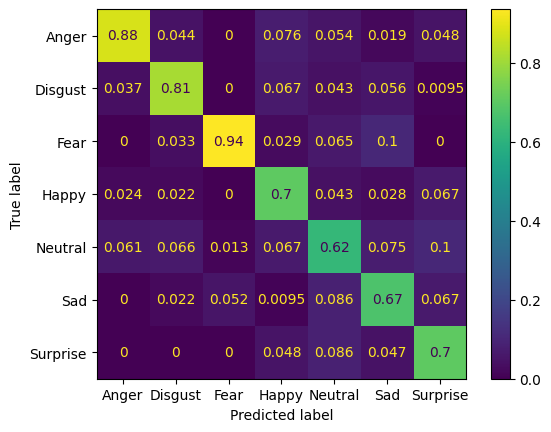

In [ ]:
import numpy as np
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for val_face, val_background, label in zip(val_faces, val_backgrounds, val_face_labels_one_hot):
    val_face = np.reshape(val_face, (-1, 224, 224, 3))
    val_background = np.reshape(val_background, (-1, 224, 224, 3))

    # append true labels # Use extend instead of append

    # compute predictions
    preds = model.predict([val_face, val_background])

    # append predicted labels
    y_true.extend([np.argmax(label, axis=-1)] * len(val_face))
    y_pred.extend(np.argmax(preds, axis=-1).tolist())  # Use extend instead of append

# convert the true and predicted labels into tensors
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)
print(len(y_true_np))
print(len(y_pred_np))

from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_true_np, y_pred_np, normalize='pred')
print(result)

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

cm_display.plot()
plt.show()